# Analyzing CRC models

In [1]:
import re
import string
import warnings
from itertools import combinations
from pathlib import Path
from time import time
from typing import Optional, Tuple, Union

import arviz as az
import color_pal as pal
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_analysis as pmanal
import pymc3_sampling_api
import sampling_pymc3_models
import seaborn as sns
from pymc3_models import crc_models
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data_dir = Path("..", "modeling_data", "depmap_CRC_data_subsample.csv")
data = dphelp.read_achilles_data(data_dir, low_memory=False)
data.shape

(34760, 30)

## Model 1

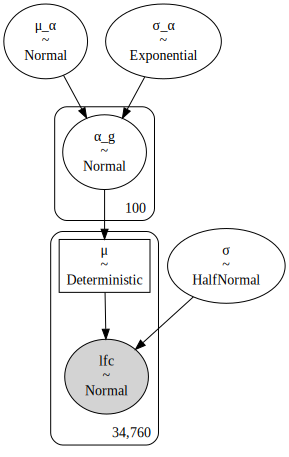

In [3]:
m1_cache_dir = pymc3_cache_dir / "CRC_test_model1"

gene_idx = dphelp.get_indices(data, "hugo_symbol")

crc_model1, gene_idx_shared, lfc_data_shared = crc_models.model_1(
    gene_idx=gene_idx, lfc_data=data.lfc.values
)
pm.model_to_graphviz(crc_model1)

In [4]:
crc_model1_res = pymc3_sampling_api.read_cached_vi(m1_cache_dir)

Loading cached trace and posterior sample...


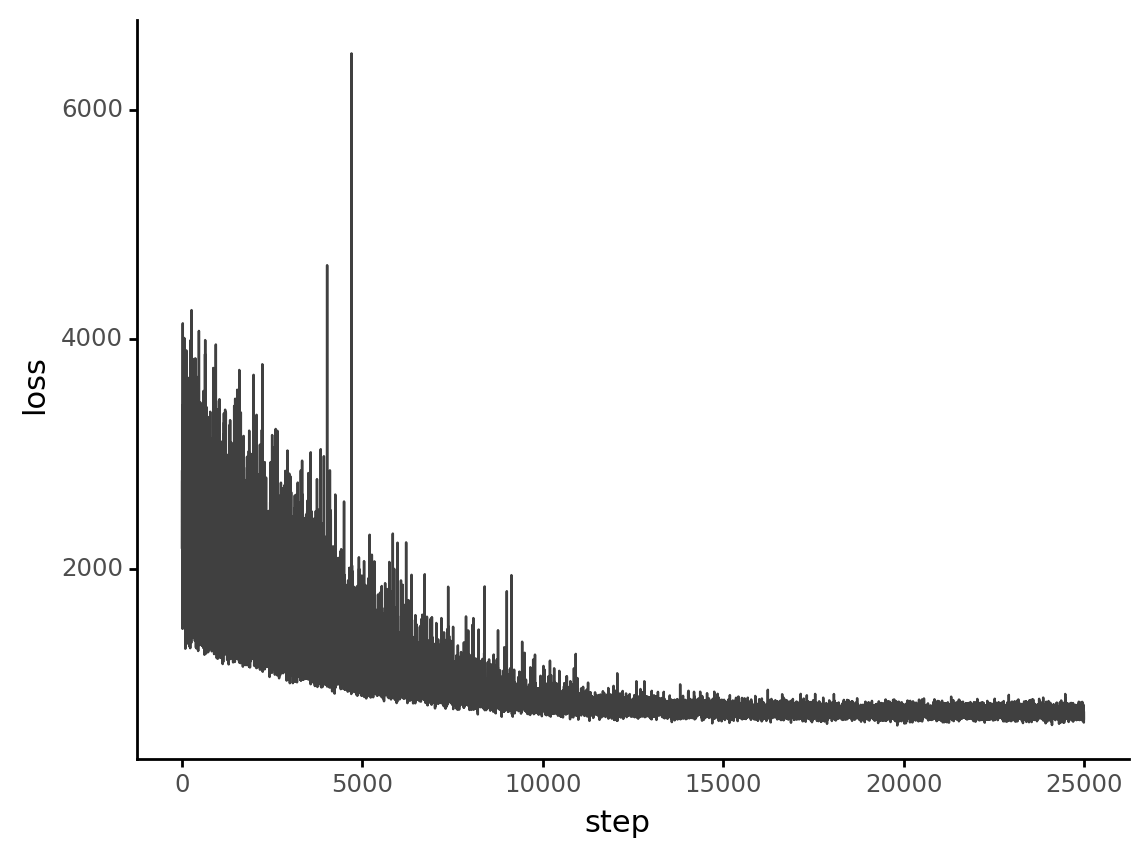

<ggplot: (8727360374733)>

In [5]:
pmanal.plot_vi_hist(crc_model1_res["approximation"])

In [6]:
m1_az = az.from_pymc3(trace=crc_model1_res["trace"], model=crc_model1)
az.summary(m1_az, var_names=["μ_α", "σ_α", "σ"], hdi_prob=0.89)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ_α -0.128  0.036    -0.186     -0.072      0.001    0.001     996.0   996.0   
σ_α  0.319  0.025     0.282      0.360      0.001    0.001    1031.0  1031.0   
σ    0.510  0.008     0.495      0.522      0.000    0.000    1038.0  1038.0   

     ess_bulk  ess_tail  r_hat  
μ_α     995.0    1024.0    NaN  
σ_α    1023.0     905.0    NaN  
σ      1035.0     862.0    NaN

In [7]:
gene_ggplot_theme = {
    "axis_text_x": gg.element_text(angle=90, size=6),
    "figure_size": (10, 6),
}


def get_varying_parameter_posterior(
    crc_az: az.InferenceData,
    var_name: str,
    data: pd.DataFrame,
    col_name: str,
    hdi_prob: float = 0.89,
) -> Tuple[pd.DataFrame, gg.ggplot]:

    gene_post = az.summary(crc_az, var_names=var_name, hdi_prob=hdi_prob, kind="stats")
    gene_post[col_name] = data[col_name].cat.categories.values
    gene_post = gene_post.merge(
        data.groupby(col_name)["lfc"].agg(np.mean).reset_index(drop=False),
        on=col_name,
    )

    p = (
        gg.ggplot(gene_post, gg.aes(x=col_name))
        + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
        + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5)
        + gg.geom_point(gg.aes(y="mean"))
        + gg.theme(**gene_ggplot_theme)
    )

    return gene_post, p

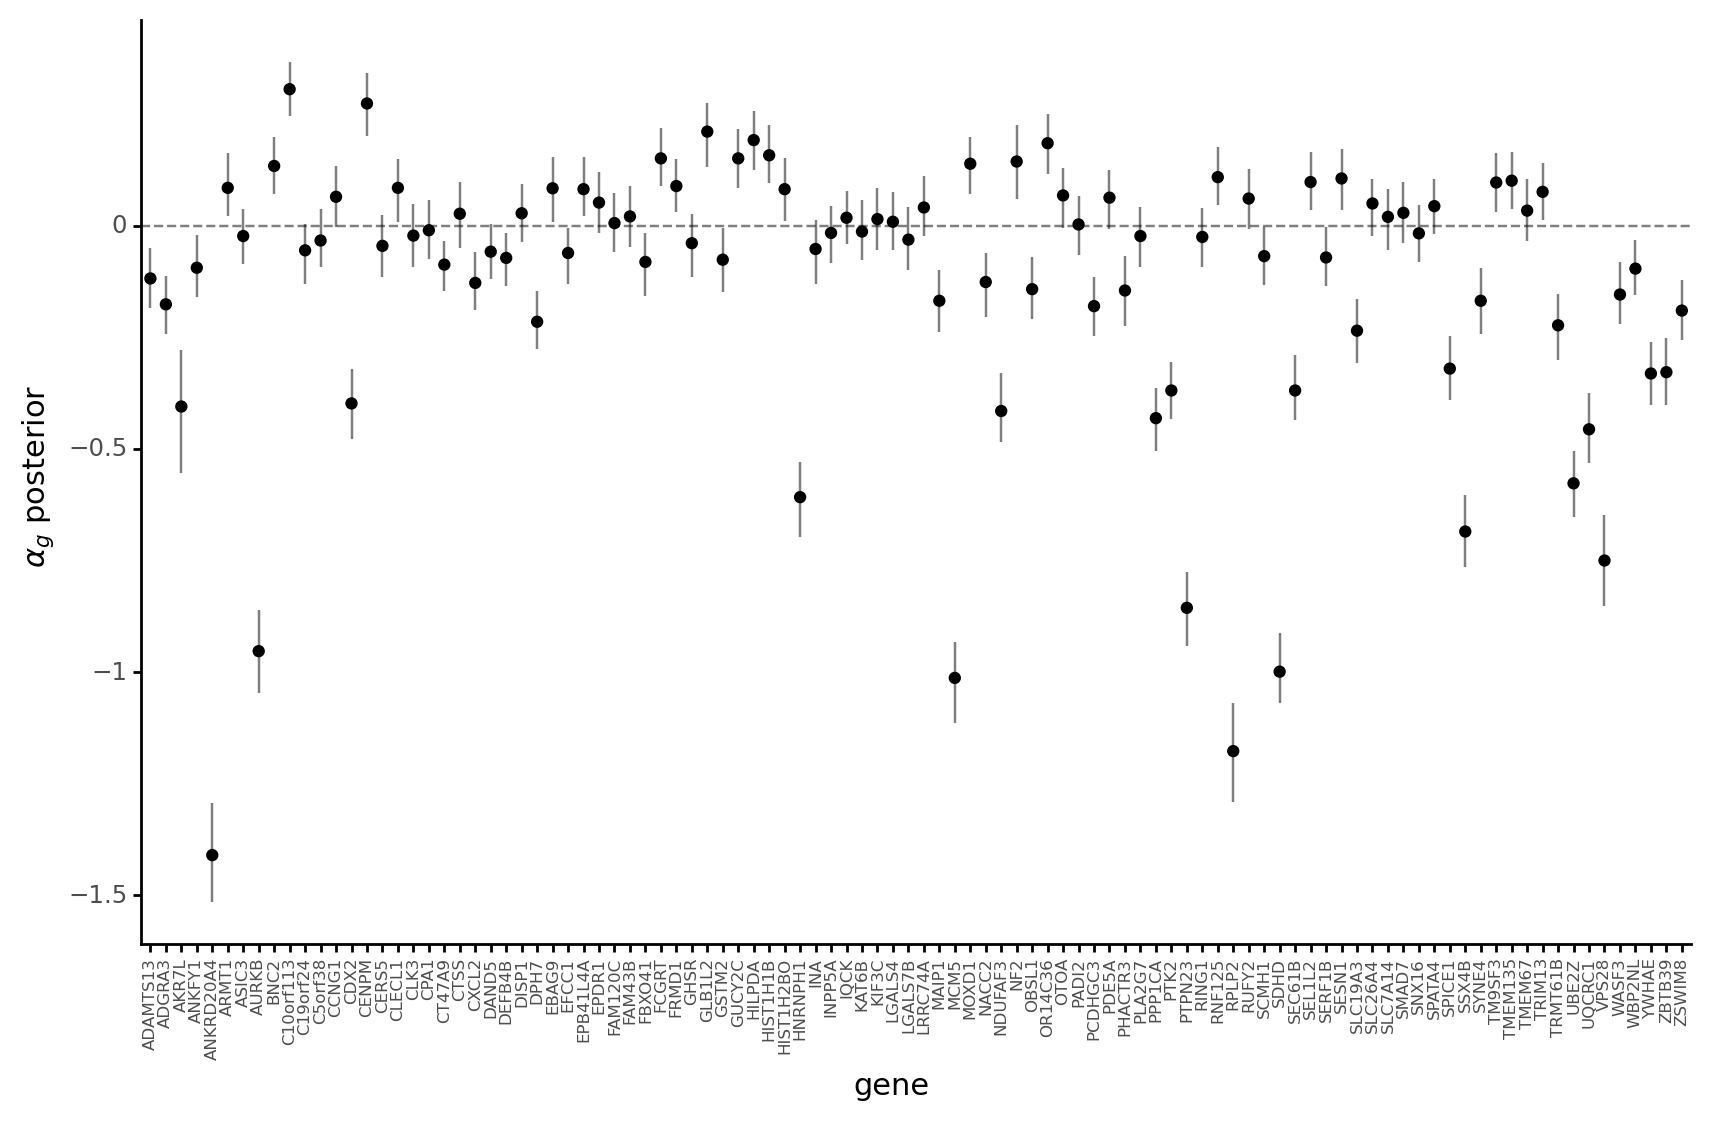

<ggplot: (8727357738876)>

In [8]:
gene_post, p = get_varying_parameter_posterior(
    m1_az, "α_g", data=data, col_name="hugo_symbol"
)
p + gg.labs(x="gene", y=r"$\alpha_g$ posterior")

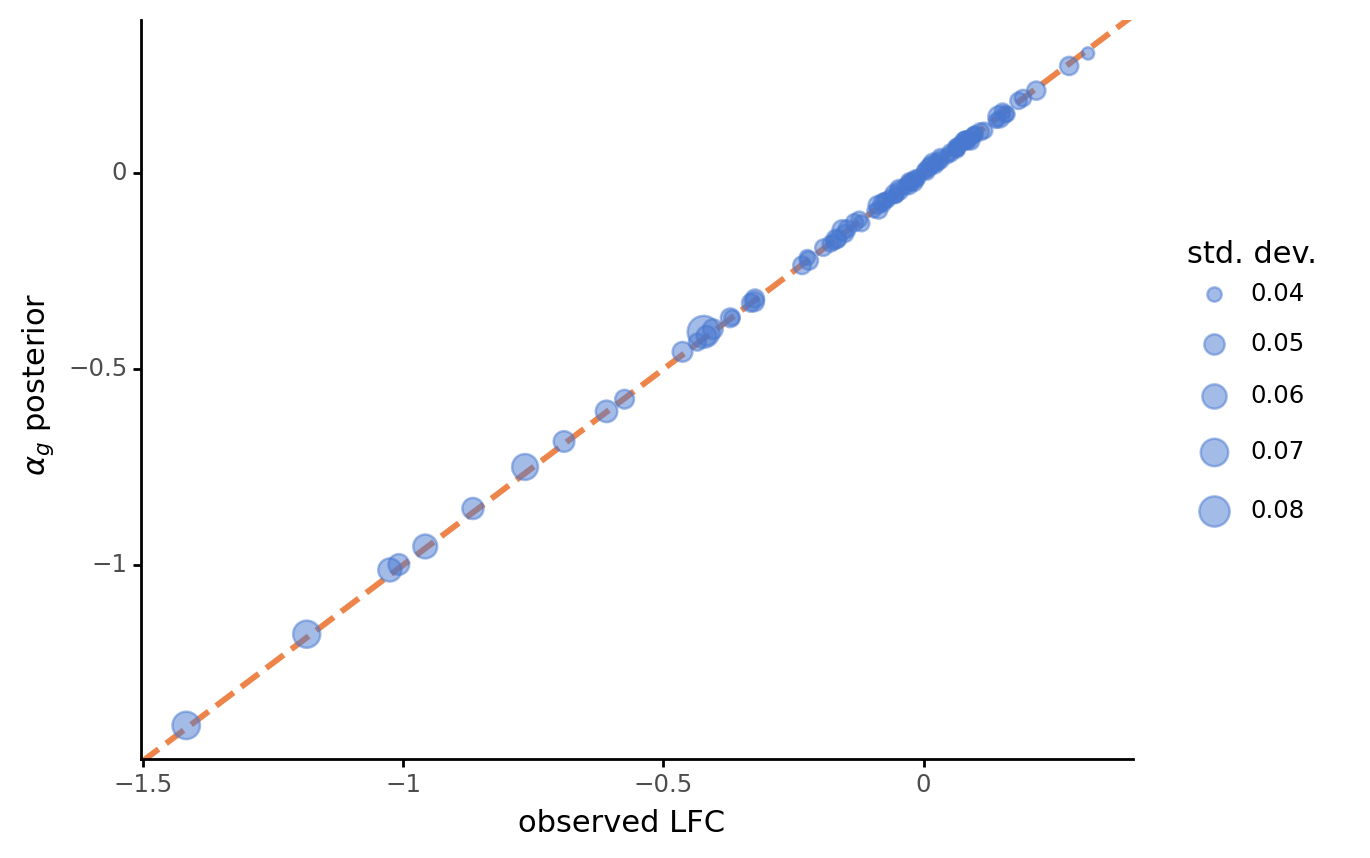

<ggplot: (8727261189708)>

In [9]:
(
    gg.ggplot(gene_post, gg.aes(x="lfc", y="mean"))
    + gg.geom_abline(
        slope=1, intercept=0, linetype="--", color=pal.sns_orange, size=1.2
    )
    + gg.geom_point(gg.aes(size="sd"), alpha=0.5, color=pal.sns_blue)
    + gg.labs(x="observed LFC", y=r"$\alpha_g$ posterior", size="std. dev.")
)

The posterior predictive check has the wrong dimensions; it is using the last minibatch for predicitions.
I need to follow the guidance of this [post](https://discourse.pymc.io/t/minibatch-advi-ppc-dimensions/5583) on the Discourse which followed the explanation in this GitHub [issue](https://github.com/pymc-devs/pymc3/issues/2190#issuecomment-311609342).
Should be a simple fix.

In [10]:
crc_model1_res["posterior_predictive"]["lfc"].shape[1] == data.shape[0]

True

In [11]:
m1_post_pred = pmanal.summarize_posterior_predictions(
    crc_model1_res["posterior_predictive"]["lfc"],
    merge_with=data[["sgrna", "hugo_symbol", "lfc"]],
)
m1_post_pred.head()

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/de1e38d7/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


pred_mean  pred_hdi_low  pred_hdi_high                 sgrna hugo_symbol  \
0  -0.140320     -1.001702       0.618150  CCACCCACAGACGCTCAGCA    ADAMTS13   
1  -0.128909     -0.896227       0.687206  CCACCCACAGACGCTCAGCA    ADAMTS13   
2  -0.144695     -0.948575       0.670772  CCACCCACAGACGCTCAGCA    ADAMTS13   
3  -0.109424     -0.900942       0.655753  CCACCCACAGACGCTCAGCA    ADAMTS13   
4  -0.141217     -1.015847       0.581773  CCACCCACAGACGCTCAGCA    ADAMTS13   

        lfc  
0  0.029491  
1  0.426017  
2  0.008626  
3  0.280821  
4  0.239815

In [12]:
def crc_post_prediction_vs_real(ppc: pd.DataFrame, color: str) -> gg.ggplot:

    return (
        gg.ggplot(ppc, gg.aes(x="lfc", y="pred_mean"))
        + gg.geom_point(gg.aes(color=color), size=0.2, alpha=0.5)
        + gg.geom_abline(
            slope=1, intercept=0, color="black", linetype="--", size=0.8, alpha=0.7
        )
        + gg.scale_color_discrete()
        + gg.theme(legend_position="none")
        + gg.labs(x="observed LFC", y="predicted LFC")
    )

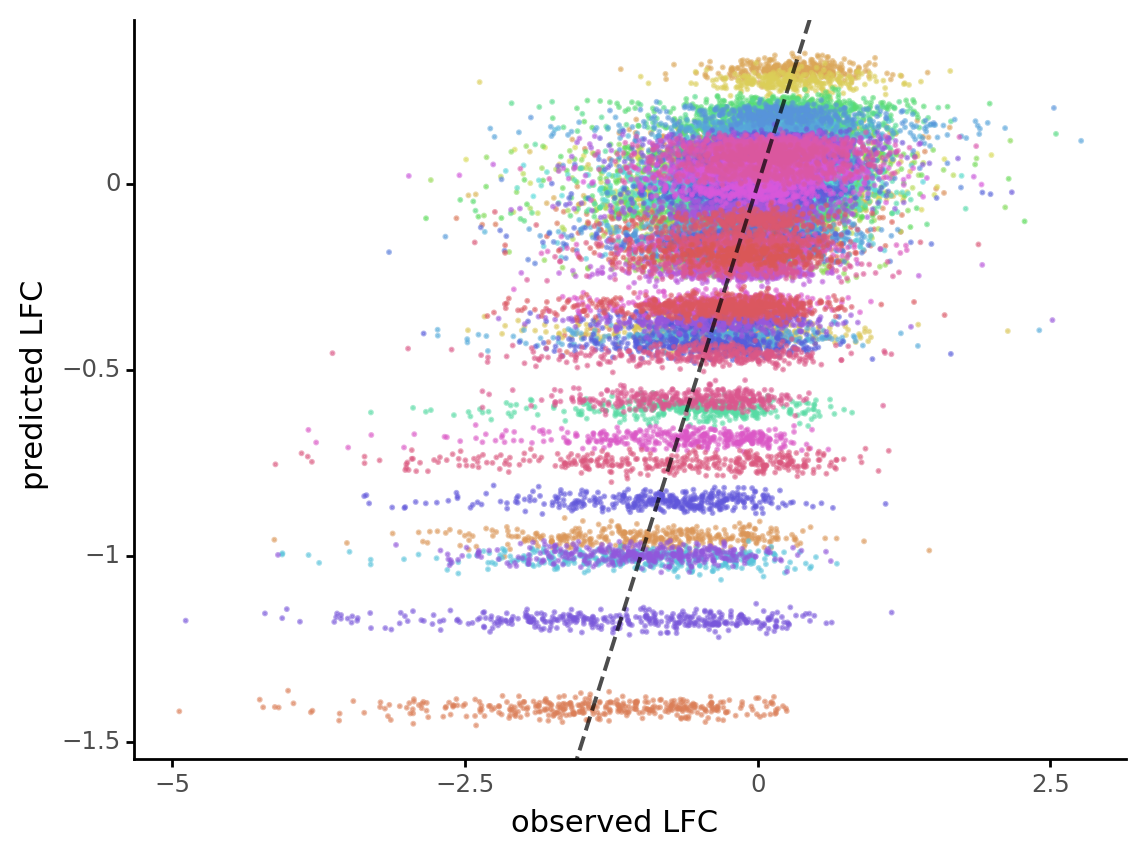

<ggplot: (8727358145431)>

In [13]:
crc_post_prediction_vs_real(m1_post_pred, "hugo_symbol")

## Predict on new data

In [14]:
pred_data = data[["hugo_symbol"]].drop_duplicates().reset_index(drop=True)

pred_gene_idx = dphelp.get_indices(pred_data, "hugo_symbol")
gene_idx_shared.set_value(pred_gene_idx)

In [15]:
with crc_model1:
    pred_ppc = pm.sample_posterior_predictive(
        trace=crc_model1_res["trace"], samples=100
    )

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/de1e38d7/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


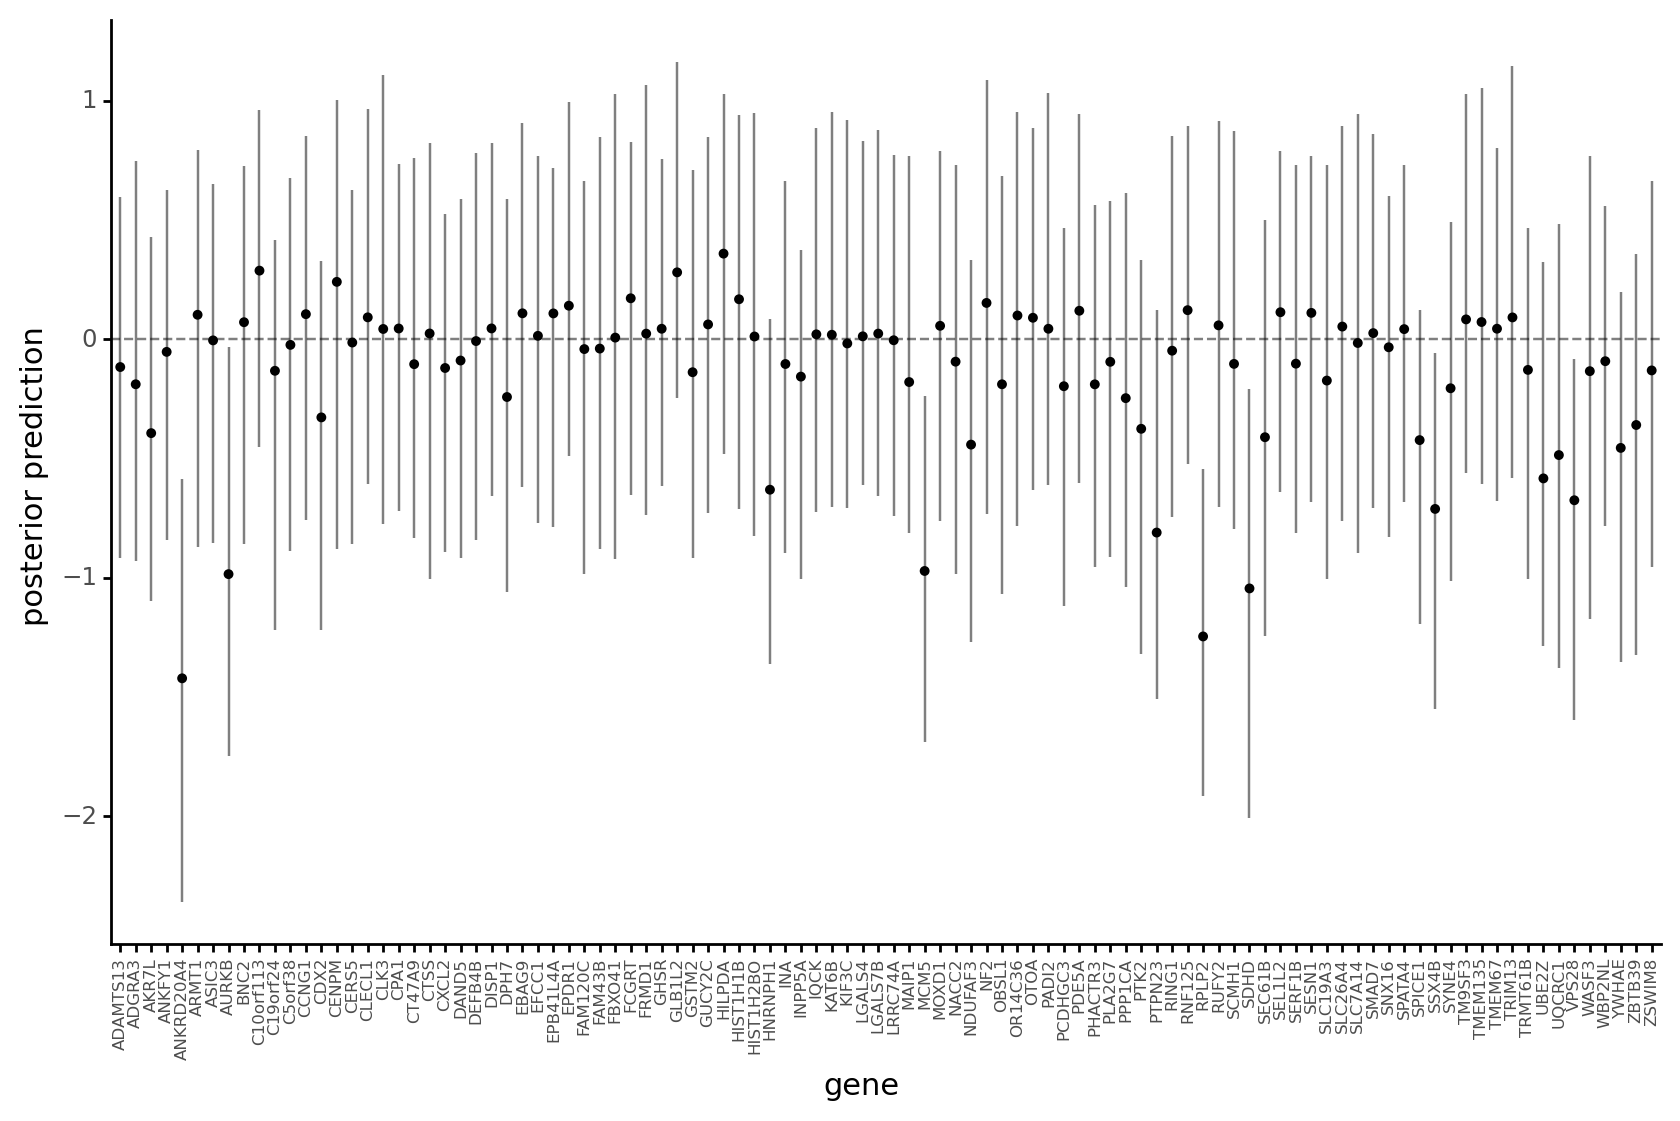

<ggplot: (8727300108183)>

In [16]:
new_ppc = pmanal.summarize_posterior_predictions(pred_ppc["lfc"])
new_ppc["hugo_symbol"] = pred_data.hugo_symbol.values
(
    gg.ggplot(new_ppc, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(
        gg.aes(ymin="pred_hdi_low", ymax="pred_hdi_high"), size=0.5, alpha=0.5
    )
    + gg.geom_point(gg.aes(y="pred_mean"), size=1)
    + gg.theme(**gene_ggplot_theme)
    + gg.labs(x="gene", y="posterior prediction")
)

## Model 2

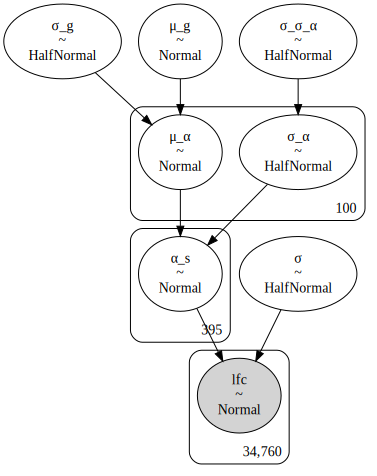

In [17]:
m2_cache_dir = pymc3_cache_dir / "CRC_test_model2"

sgrna_idx = dphelp.get_indices(data, "sgrna")
sgrna_to_gene_map = sampling_pymc3_models.make_sgrna_to_gene_mapping_df(data)
sgrna_to_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")

crc_model2, crc2_shared_vars = crc_models.model_2(
    sgrna_idx=sgrna_idx, sgrna_to_gene_idx=sgrna_to_gene_idx, lfc_data=data.lfc.values
)
pm.model_to_graphviz(crc_model2)

In [18]:
crc_model2_res = pymc3_sampling_api.read_cached_vi(m2_cache_dir)

Loading cached trace and posterior sample...


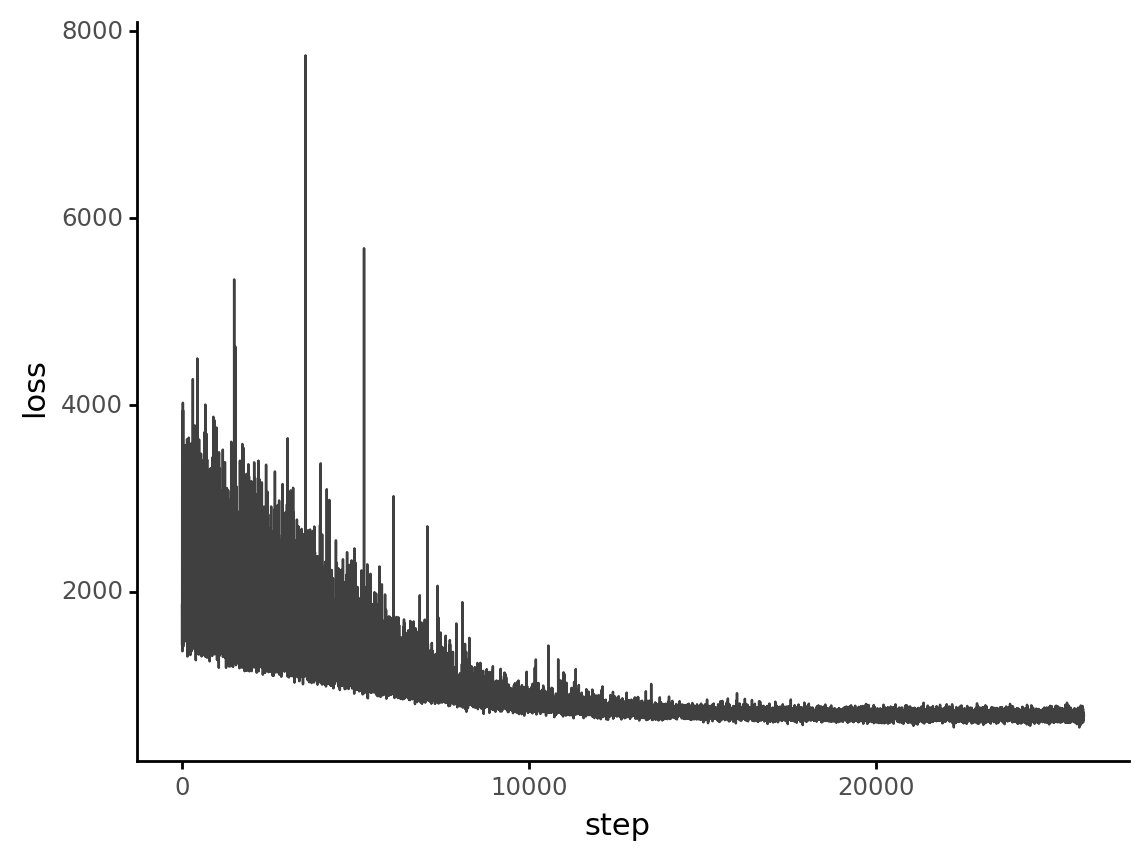

<ggplot: (8727252107581)>

In [19]:
pmanal.plot_vi_hist(crc_model2_res["approximation"])

In [20]:
m2_az = az.from_pymc3(crc_model2_res["trace"], model=crc_model2)
az.summary(m2_az, var_names=["σ_σ_α", "σ_g", "μ_g"], hdi_prob=0.89)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
σ_σ_α  0.414  0.031     0.361      0.462      0.001    0.001     985.0   
σ_g    0.250  0.020     0.217      0.279      0.001    0.000     965.0   
μ_g   -0.088  0.032    -0.137     -0.038      0.001    0.001     937.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
σ_σ_α   981.0     990.0     852.0    NaN  
σ_g     965.0     963.0     982.0    NaN  
μ_g     937.0     935.0    1026.0    NaN

array([<AxesSubplot:title={'center':'σ_σ_α'}>,
       <AxesSubplot:title={'center':'σ_g'}>,
       <AxesSubplot:title={'center':'μ_g'}>], dtype=object)

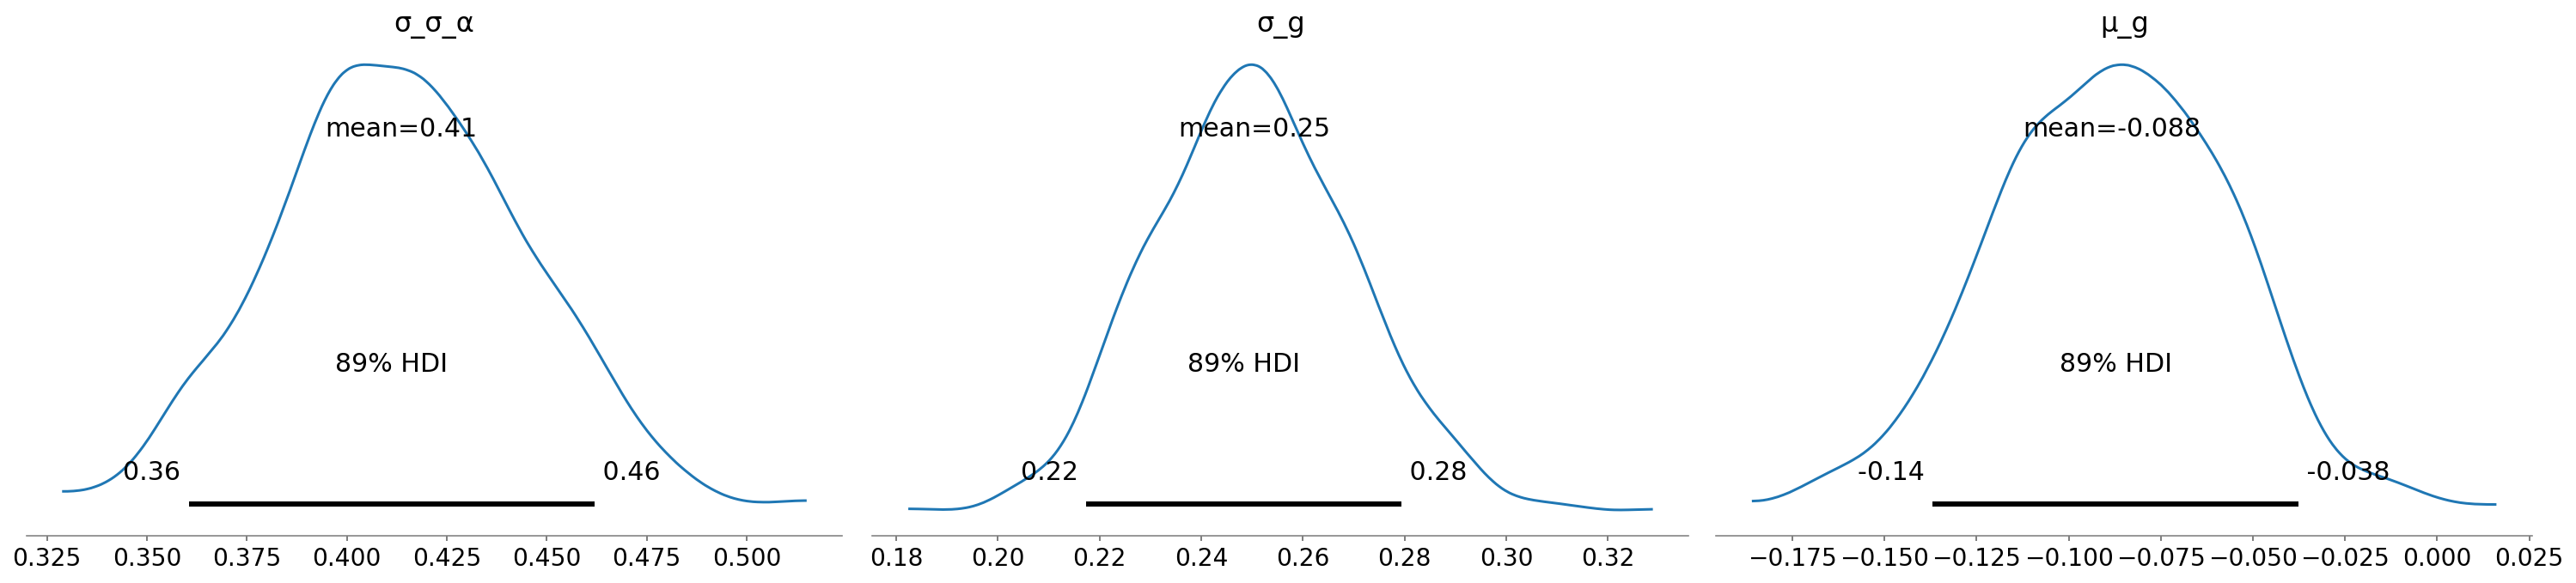

In [21]:
az.plot_posterior(m2_az, var_names=["σ_σ_α", "σ_g", "μ_g"], hdi_prob=0.89);

In [22]:
sgrna_post = (
    az.summary(m2_az, var_names="α_s", hdi_prob=0.89, kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
)
sgrna_post["sgrna"] = sgrna_to_gene_map.sgrna
sgrna_post["hugo_symbol"] = sgrna_to_gene_map.hugo_symbol

sgrna_post.head()

param   mean     sd  hdi_5.5%  hdi_94.5%                 sgrna hugo_symbol
0  α_s[0] -0.069  0.078    -0.179      0.067  CCACCCACAGACGCTCAGCA    ADAMTS13
1  α_s[1] -0.045  0.067    -0.153      0.063  CCTACTTCCAGCCTAAGCCA    ADAMTS13
2  α_s[2] -0.338  0.079    -0.455     -0.209  GTACAGAGTGGCCCTCACCG    ADAMTS13
3  α_s[3] -0.006  0.070    -0.114      0.111  TTTGACCTGGAGTTGCCTGA    ADAMTS13
4  α_s[4] -0.103  0.071    -0.209      0.013  AGATACTCTGCCCAACCGCA      ADGRA3

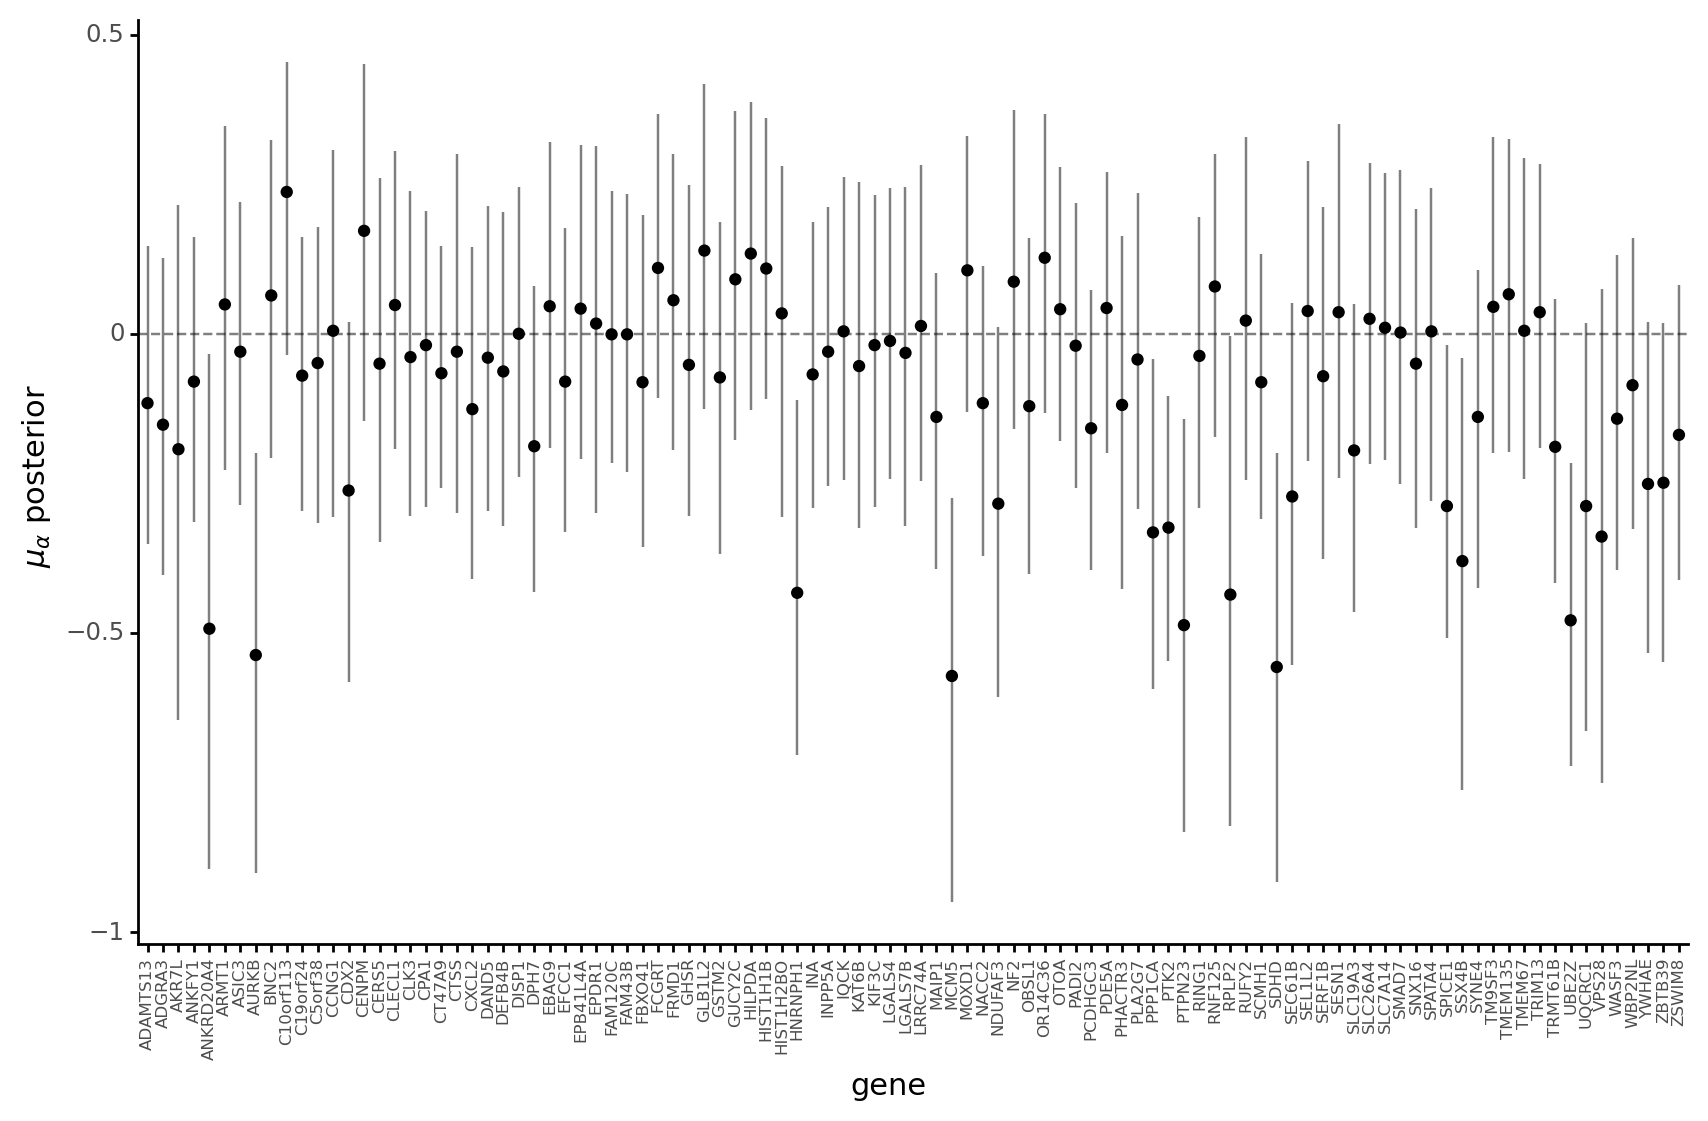

<ggplot: (8727262509999)>

In [23]:
m2_gene_post, p = get_varying_parameter_posterior(
    m2_az, var_name="μ_α", data=data, col_name="hugo_symbol"
)
p + gg.labs(x="gene", y=r"$\mu_\alpha$ posterior")

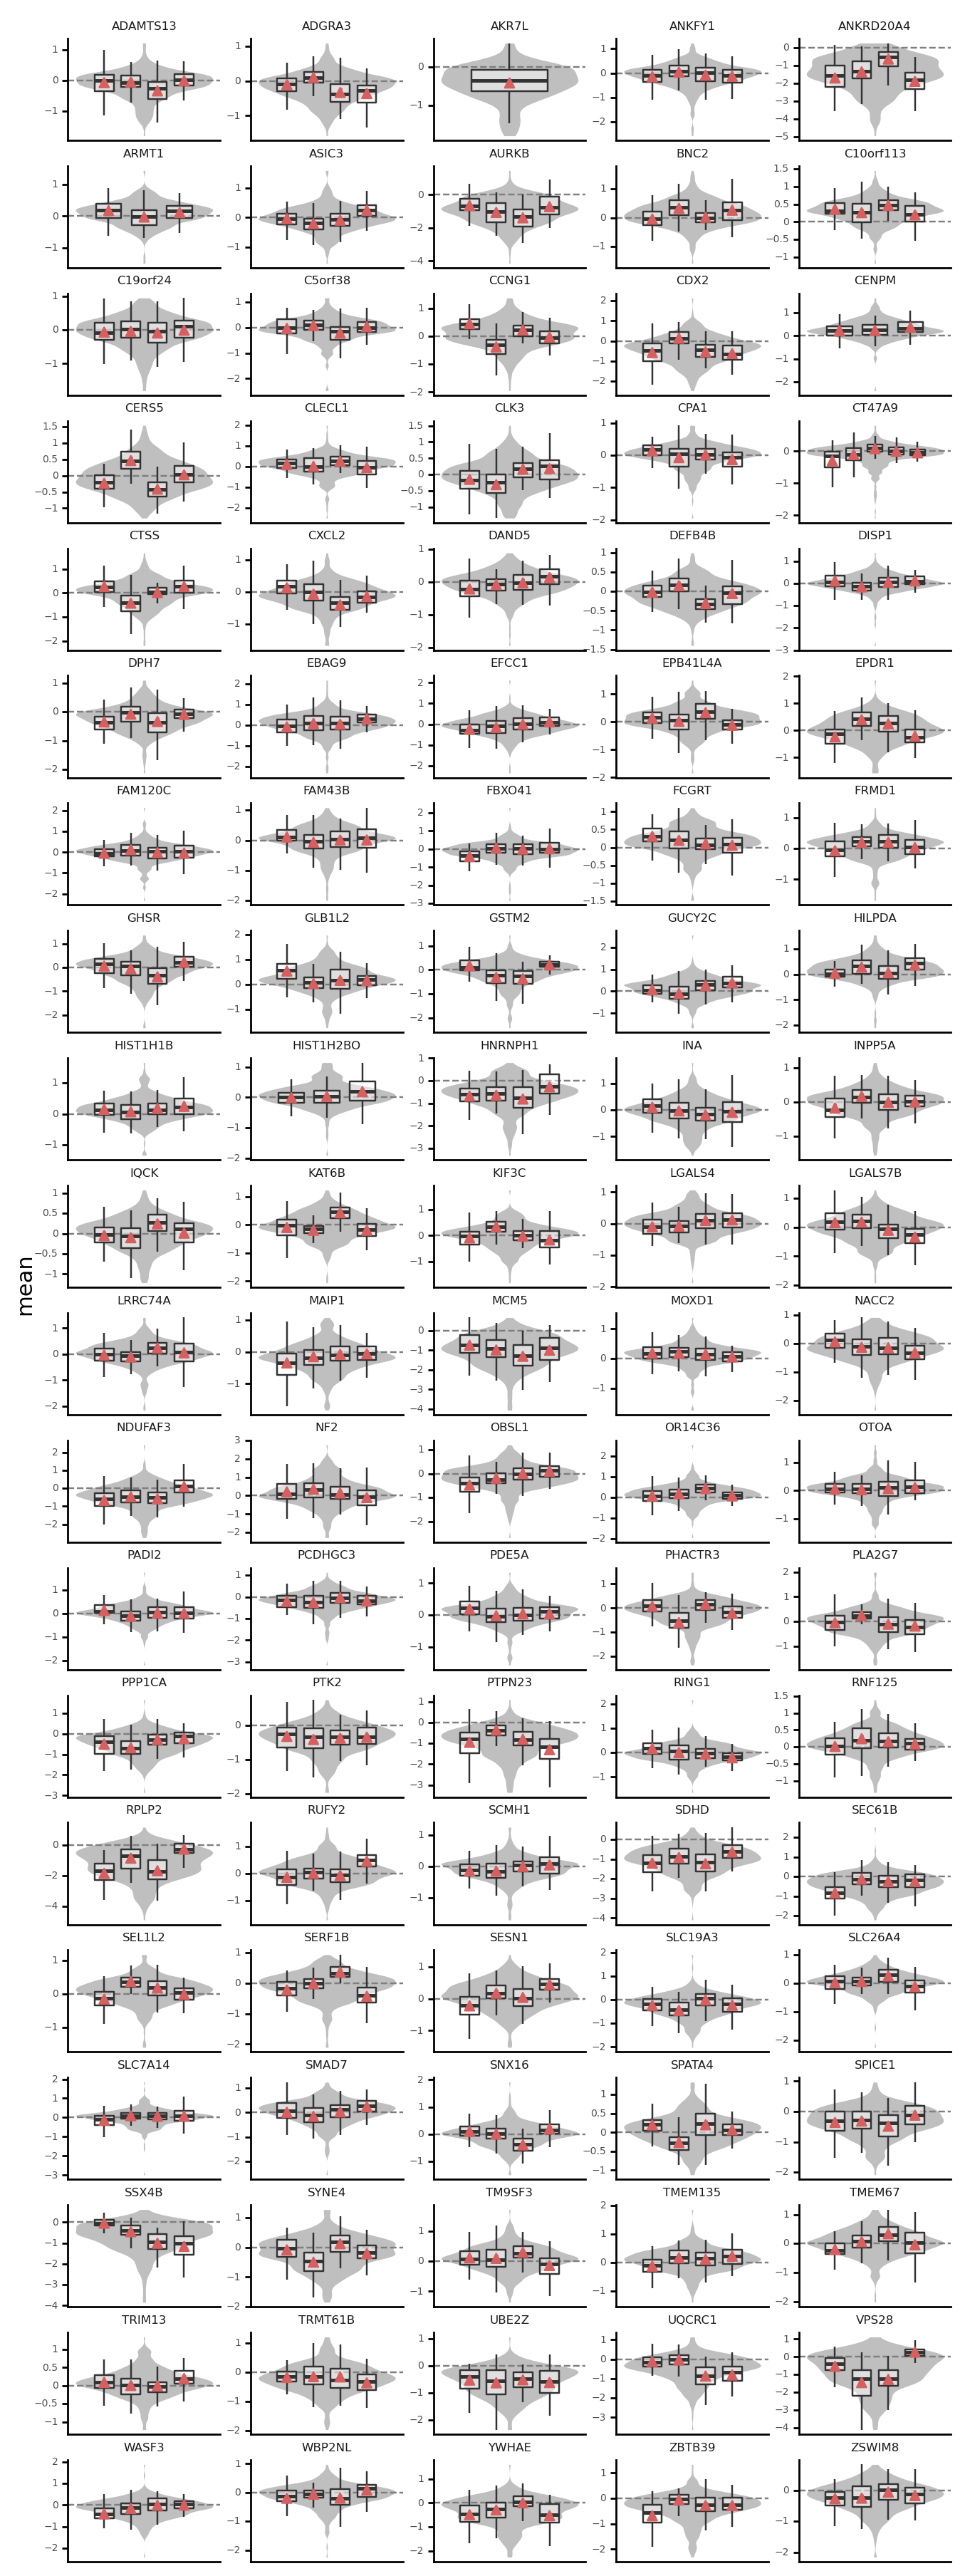

<ggplot: (8727251762173)>

In [24]:
pos = gg.position_dodge(width=0.7)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.7)

(
    gg.ggplot(sgrna_post, gg.aes(x="hugo_symbol", y="mean"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=5)
    + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5)
    + gg.geom_violin(gg.aes(y="lfc"), data=data, alpha=0.5, fill="gray", size=0)
    + gg.geom_boxplot(
        gg.aes(y="lfc", group="sgrna"),
        data=data,
        position=pos,
        alpha=0.5,
        outlier_alpha=0,
        width=0.5,
    )
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", group="sgrna"),
        position=pos,
        color=pal.sns_red,
        size=1,
    )
    + gg.geom_point(
        gg.aes(group="sgrna"), position=pos, color=pal.sns_red, size=2.2, shape="^"
    )
    + gg.theme(
        axis_text_x=gg.element_blank(),
        axis_ticks_major_x=gg.element_blank(),
        axis_title_x=gg.element_blank(),
        axis_text_y=gg.element_text(size=5),
        strip_text=gg.element_text(size=6),
        figure_size=(8, 23),
        subplots_adjust={"wspace": 0.2, "hspace": 0.25},
    )
)

In [25]:
m2_post_pred = pmanal.summarize_posterior_predictions(
    crc_model2_res["posterior_predictive"]["lfc"],
    merge_with=data[["sgrna", "hugo_symbol", "lfc"]],
)

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/de1e38d7/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [26]:
m2_post_pred.head()

pred_mean  pred_hdi_low  pred_hdi_high                 sgrna hugo_symbol  \
0  -0.042020     -0.773232       0.683600  CCACCCACAGACGCTCAGCA    ADAMTS13   
1  -0.056373     -0.872297       0.649414  CCACCCACAGACGCTCAGCA    ADAMTS13   
2  -0.094385     -0.900004       0.565439  CCACCCACAGACGCTCAGCA    ADAMTS13   
3  -0.069575     -0.797742       0.699425  CCACCCACAGACGCTCAGCA    ADAMTS13   
4  -0.061283     -0.871556       0.650743  CCACCCACAGACGCTCAGCA    ADAMTS13   

        lfc  
0  0.029491  
1  0.426017  
2  0.008626  
3  0.280821  
4  0.239815

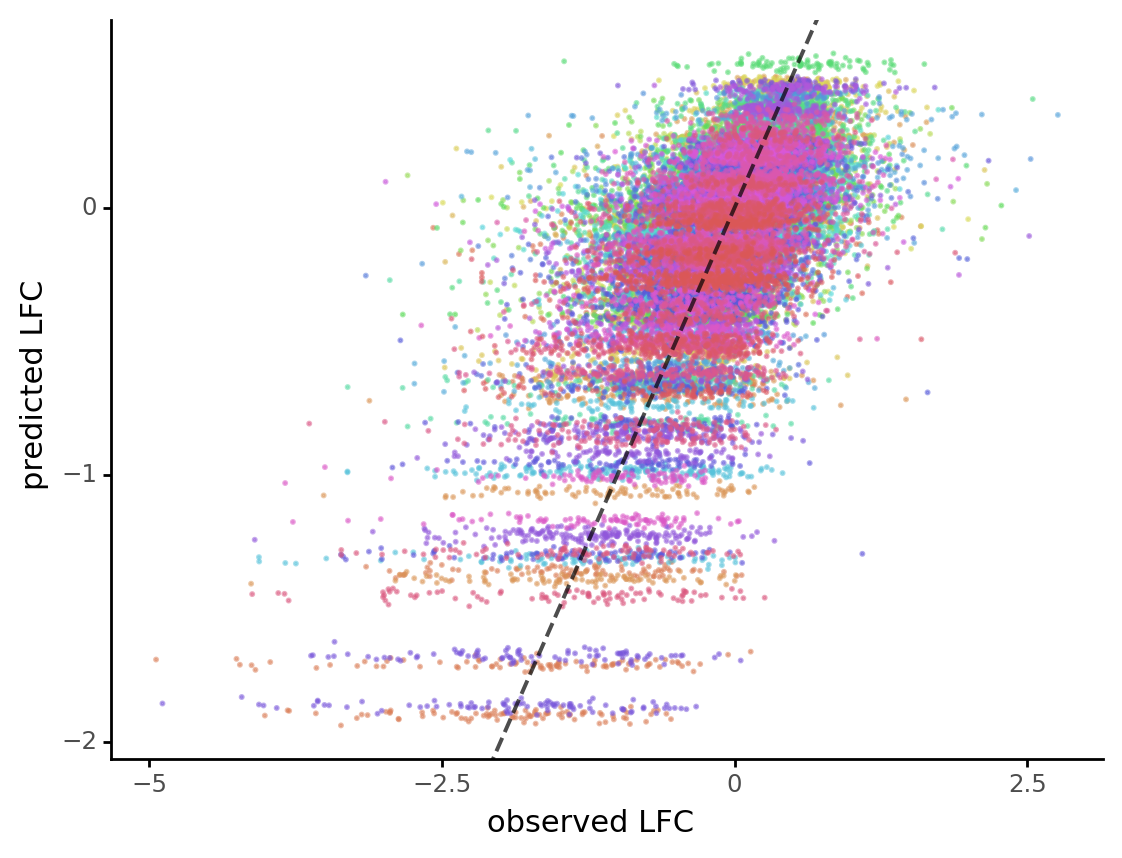

<ggplot: (8727251759668)>

In [27]:
crc_post_prediction_vs_real(m2_post_pred, "hugo_symbol")

## Model 3

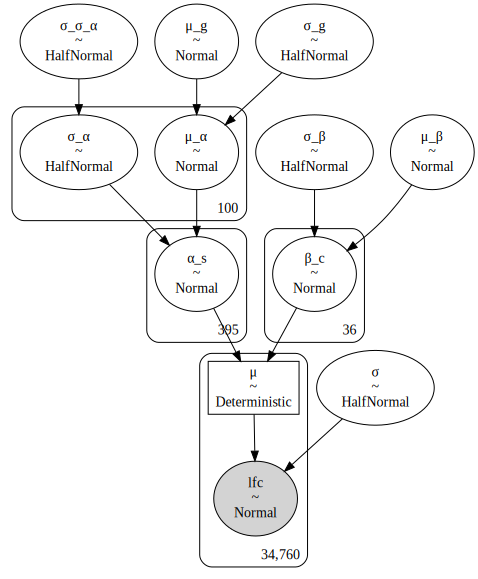

In [28]:
m3_cache_dir = pymc3_cache_dir / "CRC_test_model3"

sgrna_idx = dphelp.get_indices(data, "sgrna")
sgrna_to_gene_map = sampling_pymc3_models.make_sgrna_to_gene_mapping_df(data)
sgrna_to_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")
cell_idx = dphelp.get_indices(data, "depmap_id")

crc_model3, crc3_shared_vars = crc_models.model_3(
    sgrna_idx=sgrna_idx,
    sgrna_to_gene_idx=sgrna_to_gene_idx,
    cell_idx=cell_idx,
    lfc_data=data.lfc.values,
)
pm.model_to_graphviz(crc_model3)

In [29]:
crc_model3_res = pymc3_sampling_api.read_cached_vi(m3_cache_dir)

Loading cached trace and posterior sample...


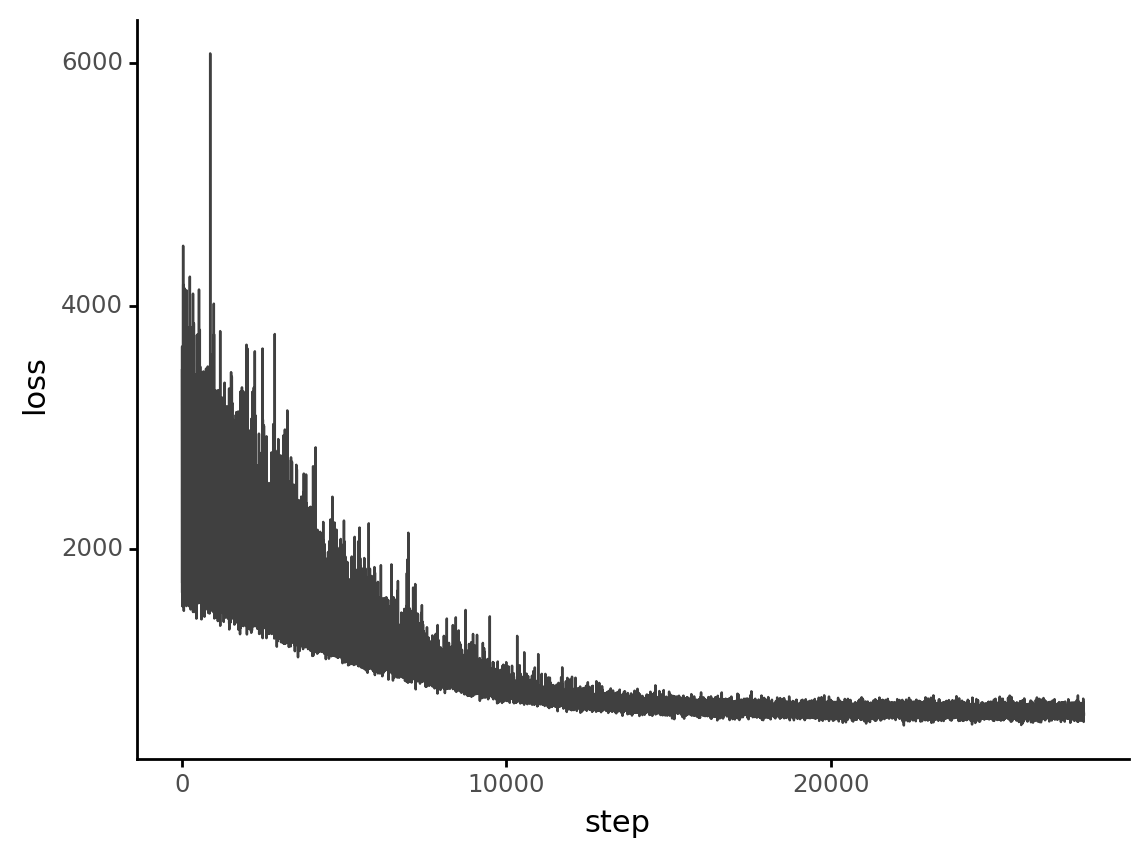

<ggplot: (8727249220747)>

In [30]:
pmanal.plot_vi_hist(crc_model3_res["approximation"])

In [31]:
m3_az = az.from_pymc3(trace=crc_model3_res["trace"], model=crc_model3)
az.summary(m3_az, var_names=["μ_g", "σ_g", "μ_β", "σ_β", "σ_σ_α"], hdi_prob=0.89)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
μ_g    0.028  0.031    -0.025      0.076      0.001    0.001     850.0   
σ_g    0.240  0.019     0.209      0.269      0.001    0.000     972.0   
μ_β   -0.124  0.018    -0.153     -0.097      0.001    0.000     971.0   
σ_β    0.083  0.011     0.065      0.100      0.000    0.000     886.0   
σ_σ_α  0.390  0.031     0.347      0.444      0.001    0.001    1033.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
μ_g     850.0     848.0     942.0    NaN  
σ_g     972.0     964.0    1011.0    NaN  
μ_β     971.0     987.0     969.0    NaN  
σ_β     876.0     905.0     978.0    NaN  
σ_σ_α  1033.0    1032.0    1024.0    NaN

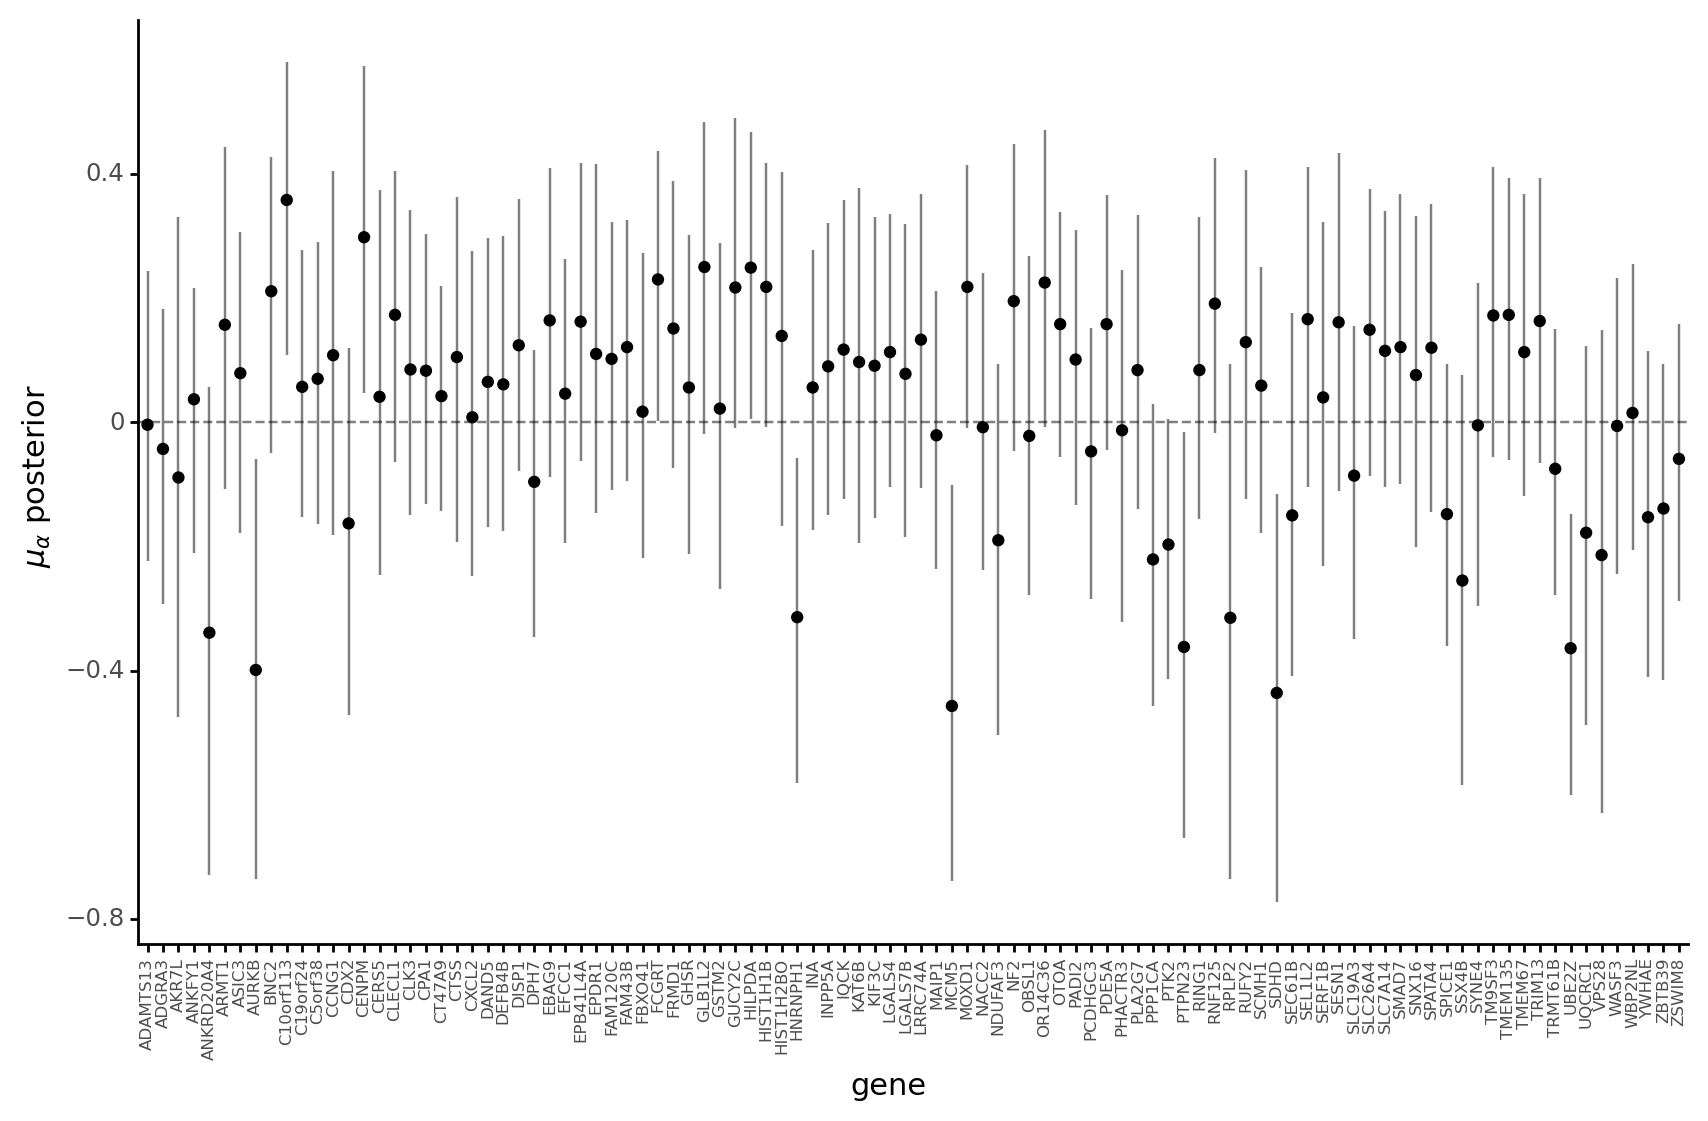

<ggplot: (8727251952668)>

In [32]:
m3_gene_post, p = get_varying_parameter_posterior(
    m3_az, var_name="μ_α", data=data, col_name="hugo_symbol"
)
p + gg.labs(x="gene", y=r"$\mu_\alpha$ posterior")

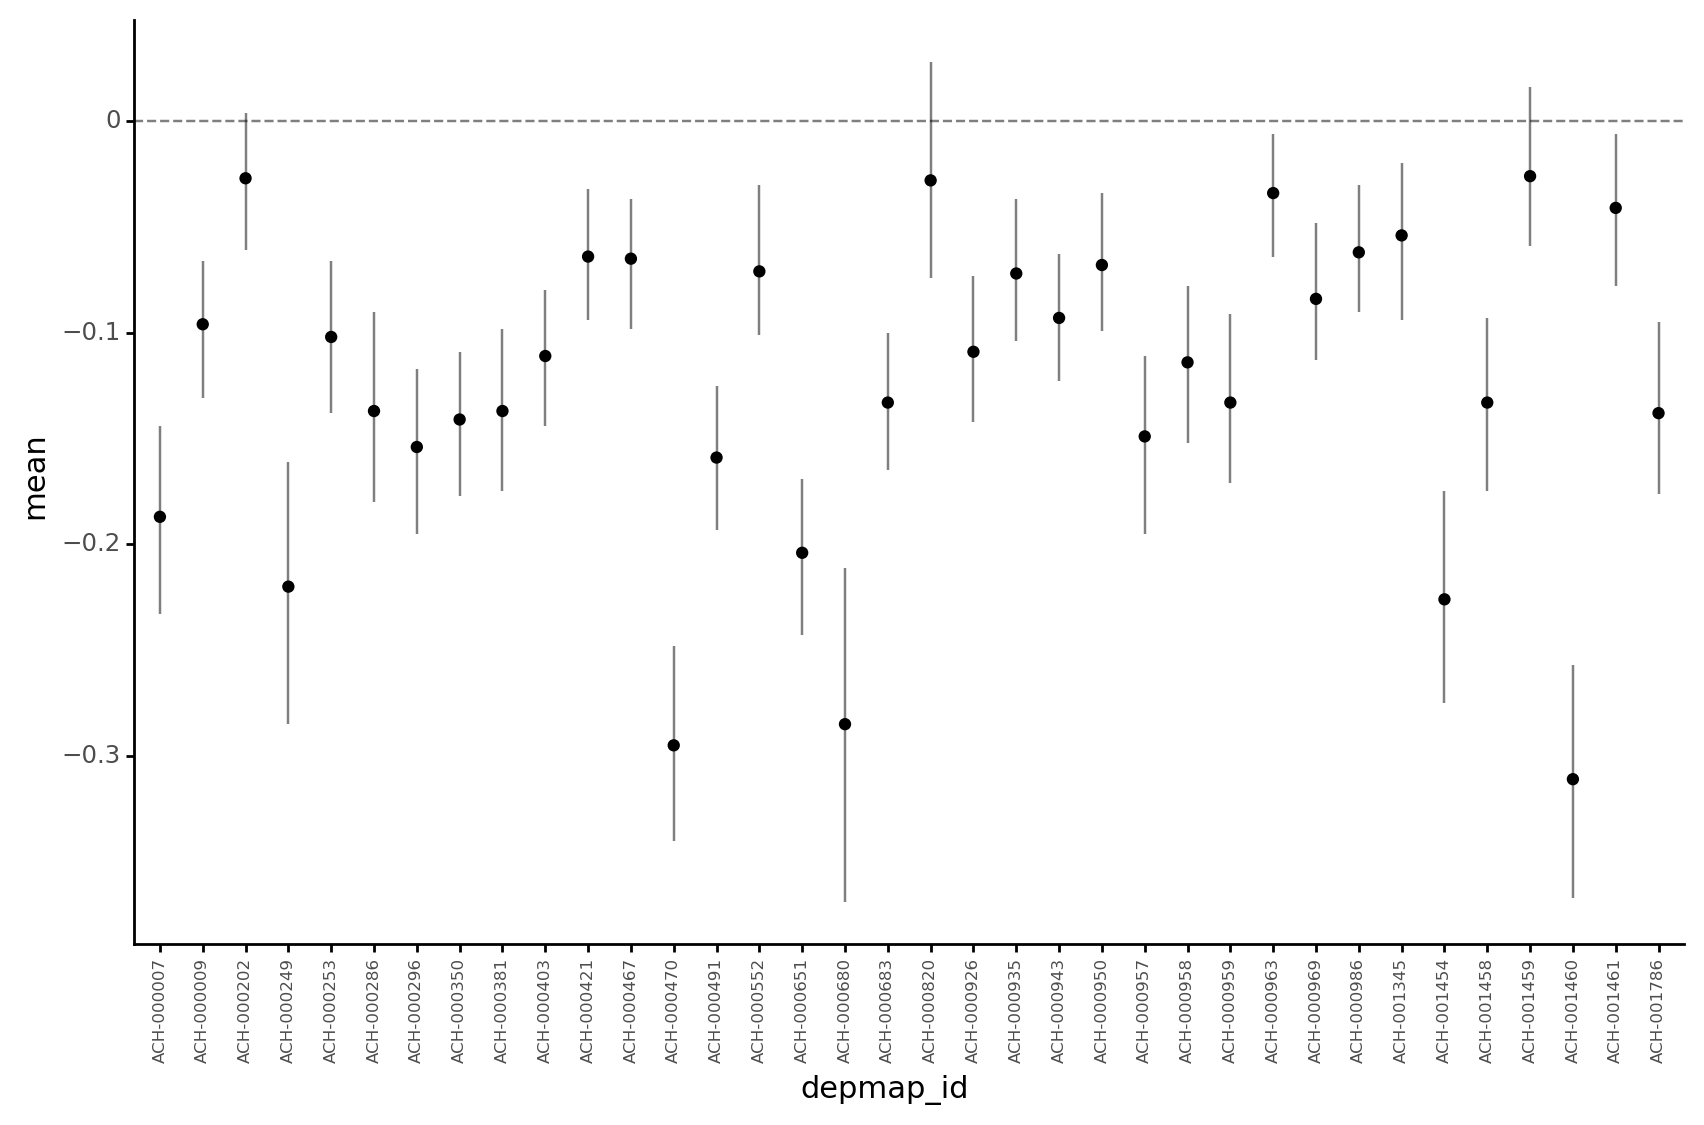

<ggplot: (8727248786372)>

In [33]:
m3_cell_post, p = get_varying_parameter_posterior(
    m3_az, var_name="β_c", data=data, col_name="depmap_id"
)
p

In [34]:
m3_post_pred = pmanal.summarize_posterior_predictions(
    crc_model3_res["posterior_predictive"]["lfc"],
    merge_with=data[["sgrna", "hugo_symbol", "lfc", "depmap_id"]],
)
m3_post_pred.head()

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/de1e38d7/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


pred_mean  pred_hdi_low  pred_hdi_high                 sgrna hugo_symbol  \
0  -0.158881     -0.999346       0.468458  CCACCCACAGACGCTCAGCA    ADAMTS13   
1  -0.124904     -0.840956       0.577671  CCACCCACAGACGCTCAGCA    ADAMTS13   
2  -0.063295     -0.810069       0.601717  CCACCCACAGACGCTCAGCA    ADAMTS13   
3  -0.038658     -0.655215       0.808753  CCACCCACAGACGCTCAGCA    ADAMTS13   
4  -0.049714     -0.866691       0.622499  CCACCCACAGACGCTCAGCA    ADAMTS13   

        lfc   depmap_id  
0  0.029491  ACH-000007  
1  0.426017  ACH-000007  
2  0.008626  ACH-000009  
3  0.280821  ACH-000009  
4  0.239815  ACH-000009

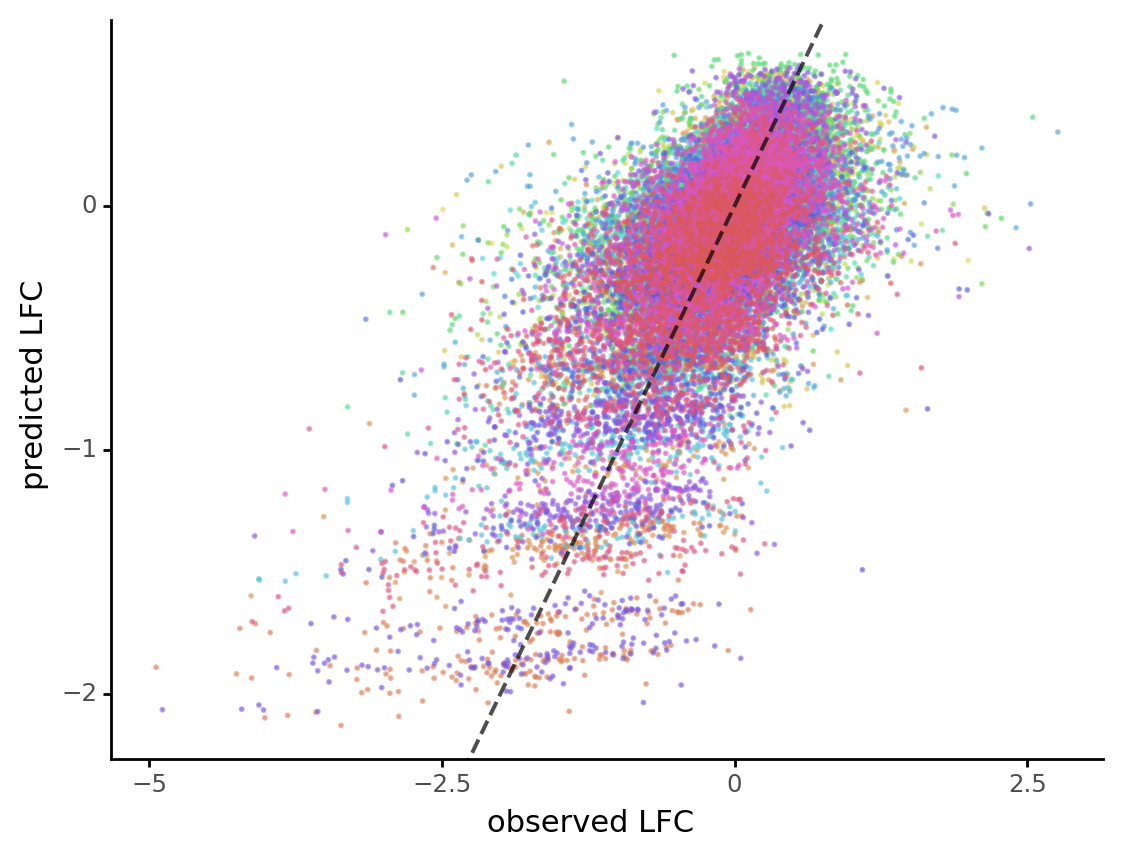

<ggplot: (8727248774702)>

In [35]:
crc_post_prediction_vs_real(m3_post_pred, "hugo_symbol")

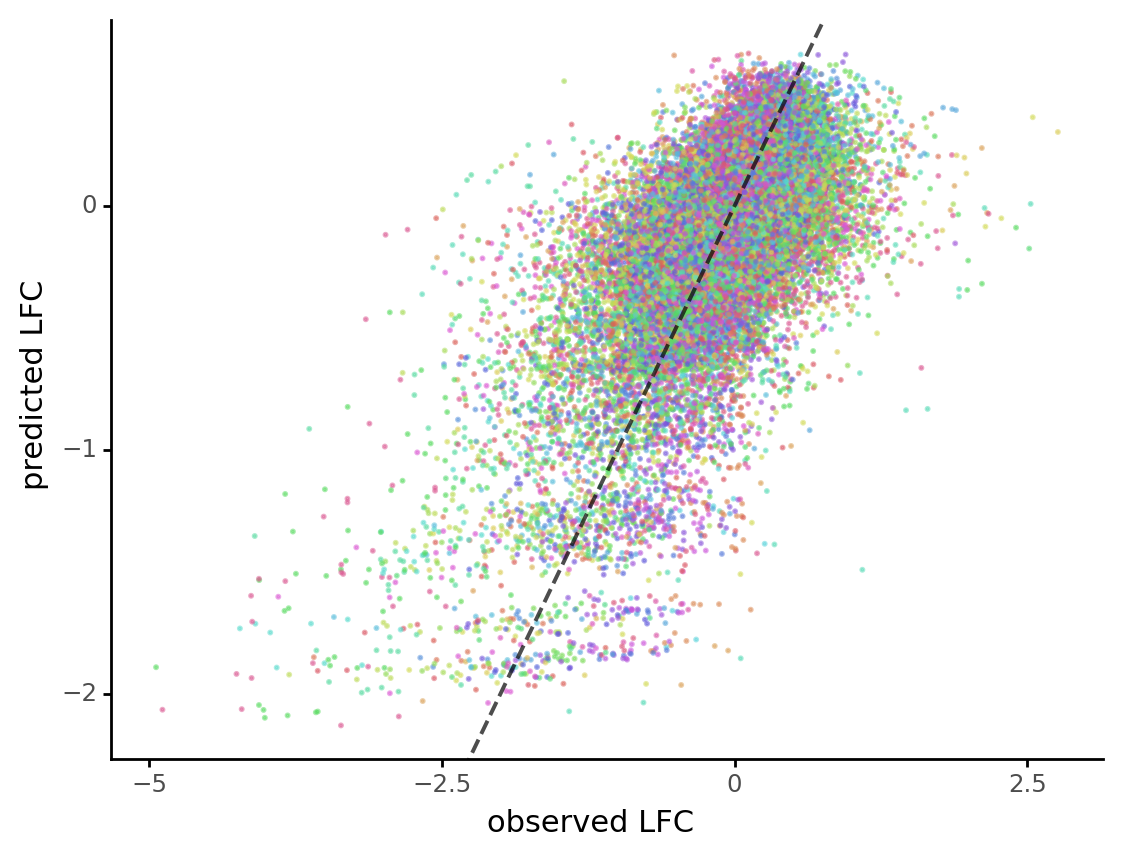

<ggplot: (8727248788324)>

In [36]:
crc_post_prediction_vs_real(m3_post_pred, "depmap_id")

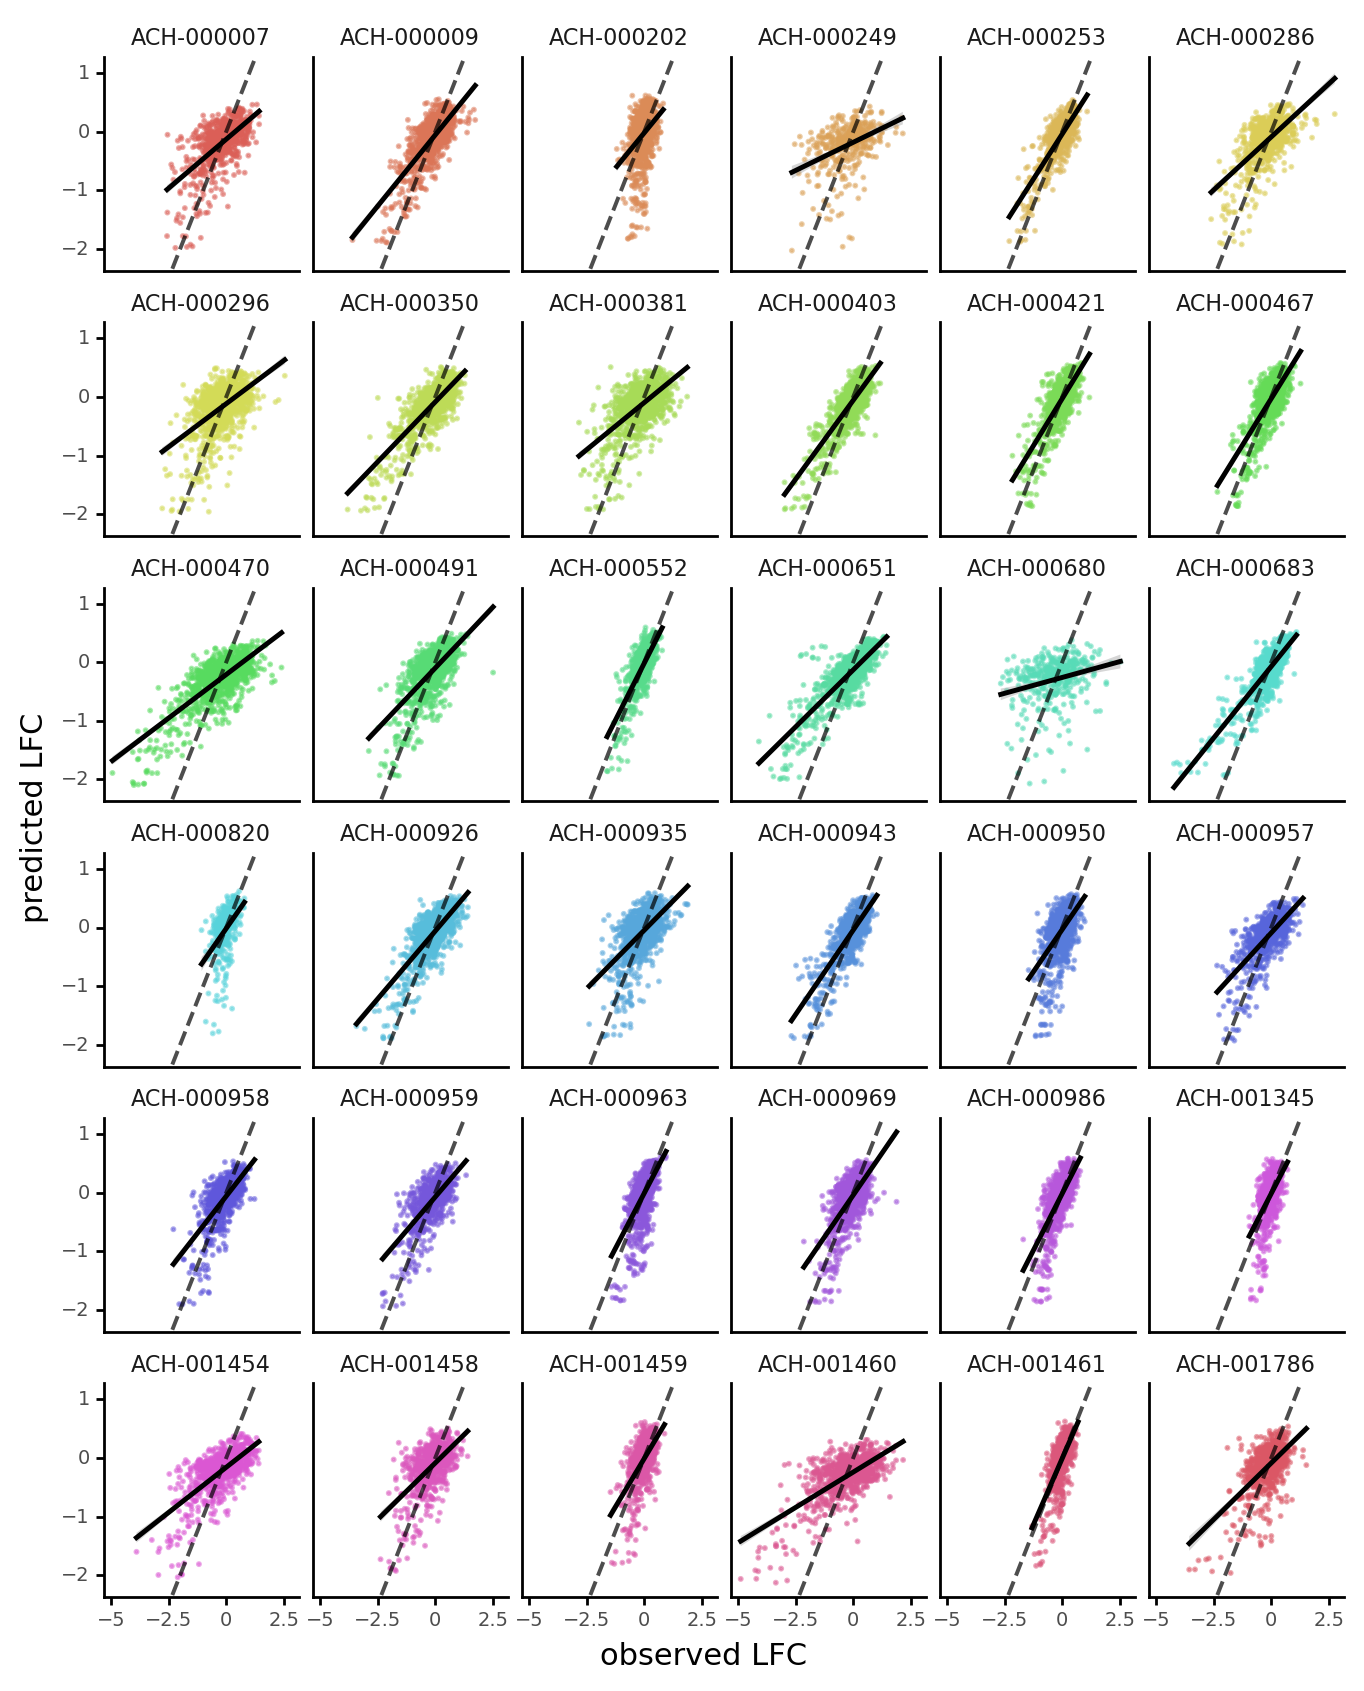

<ggplot: (8727248579527)>

In [37]:
crc_post_prediction_vs_real(m3_post_pred, "depmap_id") + gg.facet_wrap(
    "depmap_id"
) + gg.geom_smooth(method="lm", color="black", linetype="-") + gg.theme(
    figure_size=(8, 10),
    axis_text=gg.element_text(size=7),
    strip_text=gg.element_text(size=8),
)

---

## Comparing models

In [38]:
def preprocess_post(d: pd.DataFrame, name: str) -> pd.DataFrame:
    return d.assign(error=lambda d: d.pred_mean - d.lfc, model=name).reset_index(
        drop=False
    )


post_dfs = [m1_post_pred, m2_post_pred, m3_post_pred]
model_names = ["model " + str(i + 1) for i in range(len(post_dfs))]

model_errors = pd.concat([preprocess_post(d, n) for d, n in zip(post_dfs, model_names)])

In [39]:
model_errors_wide = pd.pivot(
    model_errors,
    index=["index", "hugo_symbol", "sgrna", "lfc"],
    columns="model",
    values="error",
).reset_index(drop=False)

In [40]:
def plot_model_errors(df: pd.DataFrame, x: str, y: str) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x=x, y=y))
        + gg.geom_point(size=0.2, alpha=0.5, color=pal.sns_blue)
        + gg.geom_hline(yintercept=0)
        + gg.geom_vline(xintercept=0)
        + gg.geom_abline(slope=1, intercept=0, color="black", linetype="--")
        + gg.geom_smooth(method="lm", color=pal.sns_orange)
    )

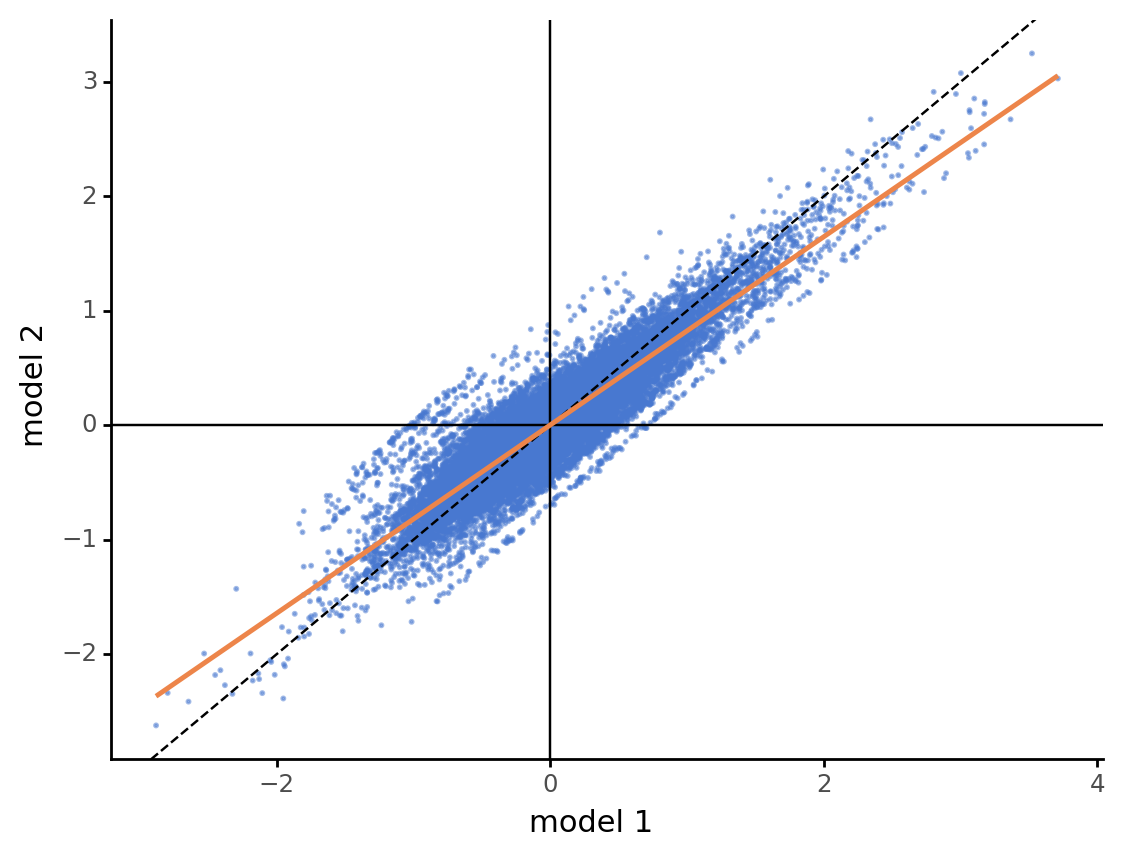

<ggplot: (8727248570838)>


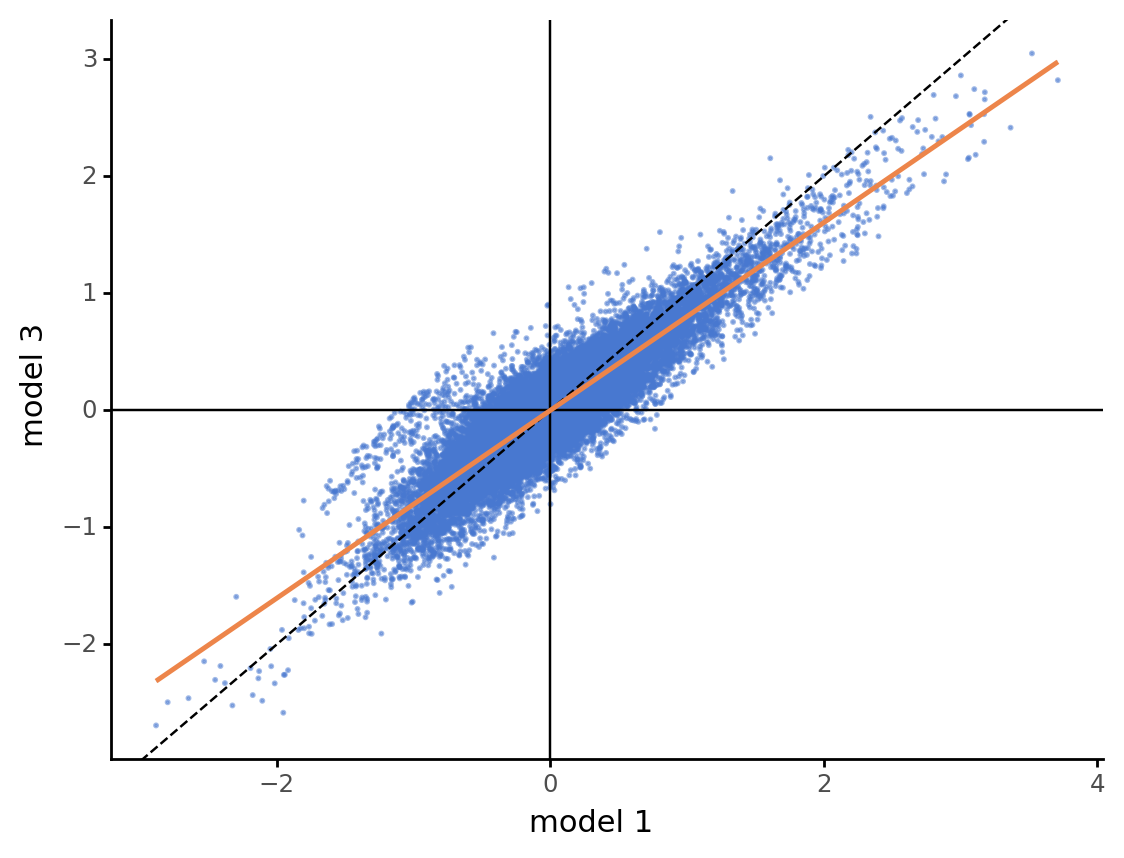

<ggplot: (8727250341042)>


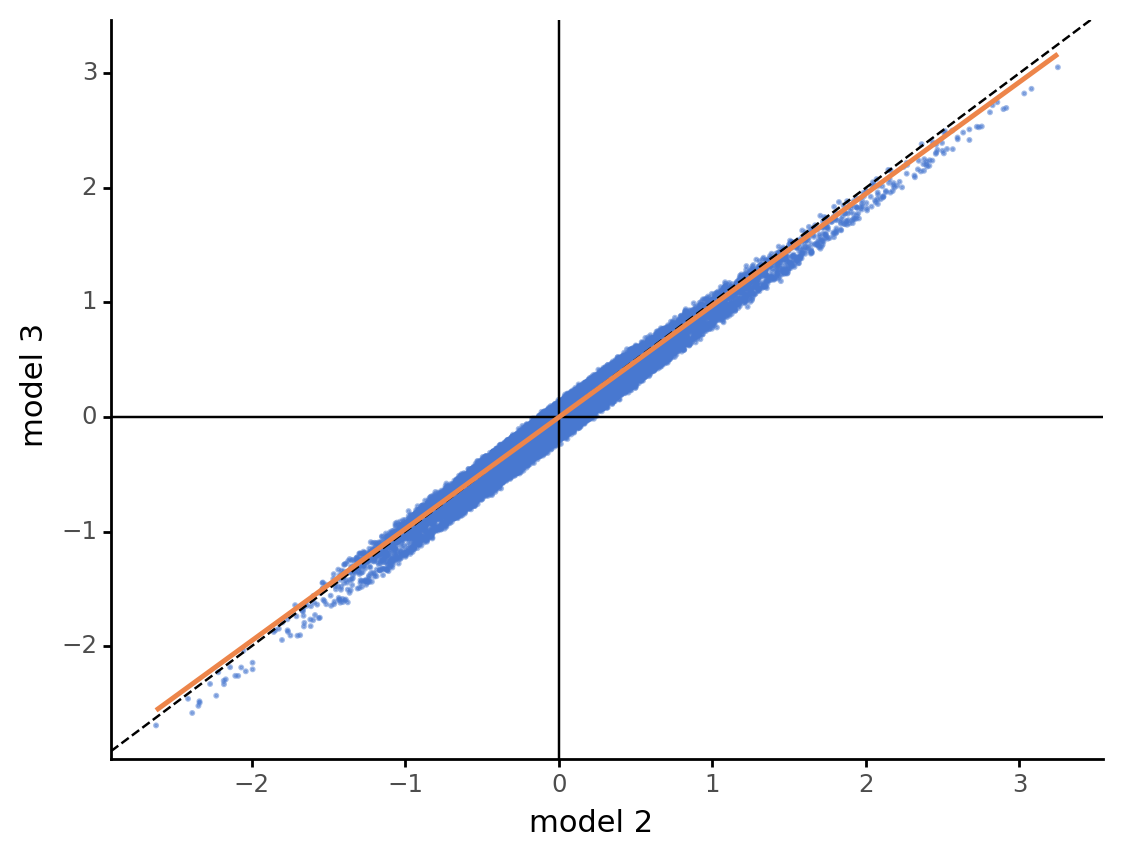

<ggplot: (8727248492114)>


In [41]:
for m1, m2 in combinations(model_names, 2):
    print(plot_model_errors(model_errors_wide, m1, m2))

In [42]:
az.compare(
    {
        "model 1": m1_az,
        "model 2": m2_az,
        "model 3": m3_az,
    }
)

rank           loo        p_loo        d_loo    weight          se  \
model 3     0 -22846.189424  1122.384028     0.000000  0.832867  207.482992   
model 2     1 -23266.448833  1117.363259   420.259409  0.077806  215.781882   
model 1     2 -26010.197079   364.108481  3164.007655  0.089327  212.227674   

               dse  warning loo_scale  
model 3   0.000000    False       log  
model 2  38.868047     True       log  
model 1  97.974332    False       log

---

### To-Do:

1. Address the change above to fix an issue with PPC sampling. <span style="color:green">✔︎</span>
2. Make sure I can replace the shared data with new data for predictions on unseen data. <span style="color:green">✔︎</span>
3. Run and analyze more simple models. <span style="color:green">✔︎</span>
4. Create a Snakemake workflow to run all in parallel and then run the analysis.

---

In [43]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.77 minutes


In [44]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-22

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-237.o2.rc.hms.harvard.edu

Git branch: crc

numpy     : 1.20.1
matplotlib: 3.3.4
pymc3     : 3.11.1
pandas    : 1.2.2
re        : 2.2.1
arviz     : 0.11.1
seaborn   : 0.11.1
plotnine  : 0.7.1
theano    : 1.0.5

